## Pitch Modeling

Goals for a new approach to pitch modeling:

- Improve the target variable. Most stuff models use target metrics like context-neutral re24/re288 run values, context-specific run values like `delta_run_exp`, or called/swinging strike rate (CSW%). My approach will use expected run value as seen in expected wOBA, which uses exit velocity and launch angle to predict wOBA. I won't be using wOBA as a base metric due to reasons I've discussed [here](https://sam-walsh.github.io/posts/fixing-xwoba/) and [here](https://sam-walsh.github.io/posts/double-plays/). Instead I will be predicting RE288 run values for balls in play with expected outcomes to reduce the noise of the target metric, while still taking into account context-specific outcomes like double plays and sacrifice flies.

- Improve location modeling. Scott Powers, former Dodgers Analyst, and Professor of Sports Analytics and his student Vicente Iglesias recently gave a presentation at Saberseminar about improving location modeling using bayesian hierarchical models. More about that [here](https://github.com/saberpowers/predictive-pitch-score). I will be taking a similar approach which will help improve location modeling, especially in small sample sizes.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import pybaseball as pb
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsRegressor

pd.set_option('display.max_columns', None)

### Data loading, merging, and transformations

Load in data from 2020-2023 seasons. 2020 was the first season where baseball-savant used hawkeye data, which includes information on the spin axis of the ball. This may help with modeling pitches that benefit from late break due to the Seam Shifted Effect. Data for observed and inferred spin axis is sourced from [baseball-savant](https://baseballsavant.mlb.com/leaderboard/spin-direction-pitches).

In [2]:
spin_dir_2023 = pd.read_csv('statcast_data/spin-direction-2023.csv')
spin_dir_2023.head()

,year,last_name,first_name,player_id,pitch_hand,api_pitch_type,n_pitches,release_speed,spin_rate,movement_inches,alan_active_spin_pct,active_spin,hawkeye_measured,movement_inferred,api_pitch_name,active_spin_formatted,hawkeye_measured_clock_minutes,movement_inferred_clock_minutes,diff_measured_inferred,diff2,diff_measured_inferred_minutes,hawkeye_measured_clock_hh,hawkeye_measured_clock_mm,movement_inferred_clock_hh,movement_inferred_clock_mm,diff_clock_hh,diff_clock_mm,hawkeye_measured_clock_label,movement_inferred_clock_label,diff_clock_label
0,NaN,Dodd,Dylan,689266,L,CH,74,83.0,1744,16.0,0.813475,0.863754,121.449207,128.145616,Changeup,86,120,105,-6.696409,6.696409,15,2,0,1,45,0,15,2:00,1:45,+0H 15M
1,NaN,Crochet,Garrett,676979,L,CH,15,90.9,2040,18.0,0.878664,0.986177,129.327497,121.167131,Changeup,99,105,120,8.160366,8.160366,-15,1,45,2,0,0,15,1:45,2:00,-0H 15M
2,NaN,Montgomery,Jordan,656756,L,CH,568,83.5,1686,15.2,0.787354,0.972753,132.920948,139.913356,Changeup,97,90,75,-6.992409,6.992409,15,1,30,1,15,0,15,1:30,1:15,+0H 15M
3,NaN,Greinke,Zack,425844,R,CH,291,86.5,1750,14.6,0.763829,0.869105,231.606343,257.664202,Changeup,87,615,570,-26.057859,26.057859,45,10,15,9,30,0,45,10:15,9:30,+0H 45M
4,NaN,Paxton,James,572020,L,CH,111,84.4,1922,16.4,0.790566,0.916634,114.396133,106.323401,Changeup,92,135,150,8.072731,8.072731,-15,2,15,2,30,0,15,2:15,2:30,-0H 15M


In [3]:
df_spin = pd.DataFrame()

spin_dir_columns = ['player_id', 'api_pitch_type', 'active_spin_formatted', 'hawkeye_measured', 'movement_inferred', 'diff_measured_inferred']
for year in range(2020, 2024):
    df_year = pd.read_csv(f"statcast_data/{year}.csv")
    spin_dir_year = pd.read_csv(f"statcast_data/spin-direction-{year}.csv")[spin_dir_columns].round(1)
    df_year = pd.merge(df_year, spin_dir_year, left_on=['pitcher', 'pitch_type'], right_on=['player_id', 'api_pitch_type'], how='left')
    df_spin = pd.concat([df_spin, df_year])


In [4]:
df_all = pd.DataFrame()
for year in range(2015, 2024):
    df_year = pd.read_csv(f'statcast_data/{year}.csv')
    df_all = pd.concat([df_all, df_year])

### Data Description

- `pitch_type`: The type of pitch thrown by the pitcher.
- `player_name`: The name of the player who threw the pitch.
- `release_speed`: The speed of the pitch at the moment it was released by the pitcher.
- `release_pos_x`: The horizontal position where the pitch was released.
- `release_pos_z`: The vertical position where the pitch was released.
- `description`: A brief description of the pitch outcome.
- `events`: The event that occurred as a result of the pitch (e.g., strike, ball, hit, etc.).
- `p_throws`: The hand with which the pitcher throws (R for right, L for left).
- `pfx_x`: The horizontal movement of the pitch, in inches, from the perspective of the pitcher.
- `pfx_z`: The vertical movement of the pitch, in inches, from the perspective of the pitcher.
- `plate_x`: The horizontal location of the pitch when it crossed home plate.
- `plate_z`: The vertical location of the pitch when it crossed home plate.
- `launch_speed`: The speed of the ball off the bat, if the pitch was hit.
- `launch_angle`: The angle at which the ball left the bat, if the pitch was hit.
- `release_spin_rate`: The spin rate of the ball when it was released by the pitcher.
- `release_extension`: The distance from the front of the pitching rubber to the point where the pitcher released the ball.
- `at_bat_number`: The number of the current at-bat in the game.
- `pitch_number`: The number of the current pitch in the at-bat.
- `delta_run_exp`: The change in expected runs from the start of the play to the end of the play.
- `active_spin_formatted`: The proportion of the total spin of the ball that contributes to its movement via magnus effect.
- `hawkeye_measured`: The measured spin direction of the ball, in degrees, from the perspective of the pitcher at release.
- `movement_inferred`: The inferred spin direction of the ball, in degrees, from the perspective of the pitcher inferred from vertical and horizontal movement.
- `diff_measured_inferred`: The difference between the measured and inferred spin direction of the ball. Corresponds to the magnitude of the seam-shifted effect.



In [5]:
df_spin.loc[:, ['pitch_type', 'player_name', 'release_speed', 'release_pos_x', 'release_pos_z', 'description', 'events', 'p_throws', 'stand', 'pfx_x', 'pfx_z', 'plate_x', 'plate_z', 'launch_speed', 'launch_angle', 'release_spin_rate', 'release_extension', 'at_bat_number', 'pitch_number', 'delta_run_exp', 'active_spin_formatted', 'hawkeye_measured', 'movement_inferred', 'diff_measured_inferred']].sample(10)

,pitch_type,player_name,release_speed,release_pos_x,release_pos_z,description,events,p_throws,stand,pfx_x,pfx_z,plate_x,plate_z,launch_speed,launch_angle,release_spin_rate,release_extension,at_bat_number,pitch_number,delta_run_exp,active_spin_formatted,hawkeye_measured,movement_inferred,diff_measured_inferred
405929,CH,"Suter, Brent",71.8,3.25,6.32,ball,NaN,L,R,0.52,0.68,2.09,3.82,NaN,NaN,1477.0,7.1,66,3,0.058,93.0,152.3,134.5,17.8
576785,FF,"Walker, Taijuan",92.4,-1.89,6.68,ball,walk,R,R,-0.79,1.47,-0.79,3.83,NaN,NaN,2144.0,5.8,9,4,0.153,97.0,215.4,210.5,4.9
88179,SI,"Alvarado, José",98.5,1.08,6.44,foul,NaN,L,L,1.27,0.87,0.85,2.86,84.4,-25.0,1949.0,6.7,55,2,-0.239,93.0,152.0,128.3,23.7
60285,CU,"Wacha, Michael",73.8,-1.36,6.70,ball,NaN,R,L,1.32,-0.30,1.19,1.66,NaN,NaN,2087.0,6.4,36,1,0.033,82.0,31.5,41.1,-9.6
556746,CH,"López, Pablo",88.5,-2.14,5.34,hit_into_play,single,R,L,-1.40,0.16,-0.49,1.86,103.4,11.0,1987.0,6.8,40,3,0.697,90.0,242.4,265.4,-23.0
466641,SI,"Alcantara, Sandy",96.9,-2.06,6.01,ball,NaN,R,R,-1.44,0.56,-0.02,3.95,NaN,NaN,2316.0,6.1,18,1,0.047,93.0,229.5,250.8,-21.2
6991,CH,"Peralta, Wandy",86.7,1.77,5.60,swinging_strike,NaN,L,R,1.18,0.54,0.36,2.19,NaN,NaN,2416.0,5.7,50,2,-0.052,88.0,126.8,104.0,22.8
563366,FF,"Senzatela, Antonio",93.1,-2.44,5.83,called_strike,NaN,R,L,-0.37,0.83,-0.60,2.88,NaN,NaN,1970.0,6.1,34,2,-0.031,82.0,205.0,199.0,6.0
583535,SI,"Ross, Joe",93.8,-3.06,5.92,foul,NaN,R,L,-0.99,0.86,-0.01,1.74,72.3,17.0,2202.0,6.6,2,1,-0.058,84.0,212.0,237.3,-25.3
544584,SI,"Smith, Riley",92.2,-1.85,5.79,foul,NaN,R,R,-1.11,1.03,0.36,2.53,75.6,37.0,2331.0,6.4,23,2,-0.052,87.0,212.5,239.0,-26.5


In [6]:
df_all.groupby('events')['delta_run_exp'].mean()

events
catcher_interf                  0.361251
caught_stealing_2b             -0.219014
caught_stealing_3b             -0.343158
caught_stealing_home           -0.346719
double                          0.765782
double_play                    -0.358528
ejection                       -0.163667
field_error                     0.449070
field_out                      -0.238023
fielders_choice                 0.697381
fielders_choice_out            -0.321947
force_out                      -0.432533
game_advisory                  -0.152222
grounded_into_double_play      -0.506435
hit_by_pitch                    0.374570
home_run                        1.375466
intent_walk                          NaN
other_out                      -0.238075
passed_ball                    -0.104143
pickoff_1b                     -0.298727
pickoff_2b                     -0.358667
pickoff_3b                     -0.266313
pickoff_caught_stealing_2b     -0.336500
pickoff_caught_stealing_3b     -0.333778
pickoff_c

### Train model to get expected run value based on launch angle and exit velocity

Calculate spray angle

In [7]:
import math

def calculate_spray_angle(df):
    # Create a copy of the dataframe to avoid modifying the original one
    df_copy = df.copy()

    # Calculate adjusted hit coordinates
    df_copy['hc_x_adj'] = df_copy['hc_x'].sub(126)
    df_copy['hc_y_adj'] = 254.5 - df_copy['hc_y']

    # Define rotation matrix
    rad = -math.pi/4
    rotation_mat = np.array([[math.cos(rad), math.sin(rad)],
                             [-math.sin(rad), math.cos(rad)]])

    # Apply rotation matrix to adjusted hit coordinates
    df_copy[['field_x', 'field_y']] = df_copy[['hc_x_adj', 'hc_y_adj']].dot(rotation_mat)

    # Calculate spray angle from inverse tangent function of transformed hit coordinates
    df_copy['theta'] = np.arctan(df_copy['field_y'].div(df_copy['field_x']))
    df_copy['spray_angle'] = df_copy['theta'].mul(180/math.pi)

    # Adjust spray angle for pull side of lefties and righties (closer to zero is pull side)
    df_copy['spray_angle_adj'] = np.where(df_copy['stand'] == 'R', df_copy['spray_angle'].mul(-1).add(90), df_copy['spray_angle'])
    df_copy['spray_angle_adj'] = (df_copy['spray_angle_adj'] / 10).round() * 10
    # Assign NaN to the rows where spray angle cannot be calculated
    df_copy.loc[df_copy[['hc_x', 'hc_y']].isna().any(axis=1), ['field_x', 'field_y', 'theta', 'spray_angle', 'spray_angle_adj']] = np.nan

    return df_copy

In [8]:
df_all = calculate_spray_angle(df_all)

In [9]:
mean_run_values_by_year = df_all.groupby(['game_year', 'events'])['delta_run_exp'].mean().round(2)
df_all['mean_run_value'] = df_all.set_index(['game_year', 'events']).index.map(mean_run_values_by_year)


In [10]:
# check if yearly implementation of linear weights is correct
df_all.loc[df_all['events']=='home_run'].groupby('game_year')['mean_run_value'].mean()

game_year
2015    1.390593
2016    1.367925
2017    1.370002
2018    1.368144
2019    1.369710
2020    1.377767
2021    1.379894
2022    1.393330
2023    1.374430
Name: mean_run_value, dtype: float64

In [11]:
## subset for balls in play with launch speed and angle
df_all_bip = df_all.dropna(subset=['launch_speed', 'launch_angle', 'spray_angle_adj', 'mean_run_value'])
df_all_bip.shape

(943352, 102)

Convert features to integers for faster training and predictions

In [36]:
df_all_bip['launch_speed'] = df_all_bip['launch_speed'].round().astype(int)
df_all_bip['launch_angle'] = df_all_bip['launch_angle'].round().astype(int)
df_all_bip['spray_angle_adj'] = df_all_bip['spray_angle_adj'].astype(int)

C:\Users\wampl\AppData\Local\Temp\ipykernel_19000\2501300249.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\wampl\AppData\Local\Temp\ipykernel_19000\2501300249.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\wampl\AppData\Local\Temp\ipykernel_19000\2501300249.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/panda

In [37]:
import xgboost as xgb
import optuna
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

## Define features and target
X = df_all_bip[['launch_speed', 'launch_angle', 'spray_angle_adj']].values
y = df_all_bip['mean_run_value'].values

## Split data into training, test and validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

In [ ]:

def objective(trial):
    param = {
        'tree_method': 'gpu_hist',  # Use GPU acceleration
        'lambda': trial.suggest_float(
            'lambda', 1e-3, 10.0, log=True
        ),
        'alpha': trial.suggest_float(
            'alpha', 1e-3, 10.0, log=True
        ),
        'colsample_bytree': trial.suggest_categorical(
            'colsample_bytree', [0.5, 0.7, 0.9, 1.0]
        ),
        'subsample': trial.suggest_categorical(
            'subsample', [0.6, 0.7, 0.8, 1.0]
        ),
        'learning_rate': trial.suggest_float(
            'learning_rate', 0.005, 0.03, log=True
        ),
        'n_estimators': trial.suggest_categorical(
            "n_estimators", [1000, 2000, 5000, 10000]
        ),
        'max_depth': trial.suggest_categorical(
            'max_depth', [2, 3, 4, 5, 7, 9, 11, 13]
        ),
        'random_state': 42,
        'min_child_weight': trial.suggest_int(
            'min_child_weight', 1, 300
        ),
    }
    model = xgb.XGBRegressor(**param)  

    model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)

    preds = model.predict(X_val)
    rmse = mean_squared_error(y_val, preds, squared=False)
    return rmse

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=25)

In [14]:
import joblib
xgb_params = study.best_params
xgb_params['random_state'] = 42
xgb_params['tree_method'] = 'gpu_hist'
xgb_reg = xgb.XGBRegressor(**xgb_params)
xgb_reg.fit(X_train, y_train)

joblib.dump(xgb_reg, 'xgb_reg.joblib')

xgb_reg = joblib.load('xgb_reg.joblib')


In [15]:

## Score the model on the test set
preds_test = xgb_reg.predict(X_test)
rmse_test = mean_squared_error(y_test, preds_test, squared=False)
print(f'Test RMSE: {rmse_test:.4f}')


Test RMSE: 0.3182


In [38]:
xgb_reg.fit(X, y)

XGBRegressor(alpha=0.11118220760567063, base_score=None, booster=None,
             callbacks=None, colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=0.0025907906864399127,
             learning_rate=0.012061421225384748, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=163, missing=nan, monotone_constraints=None,
             n_estimators=2000, n_jobs=None, num_parallel_tree=None, ...)

0
10
20
30
40
50
60
70
80
90


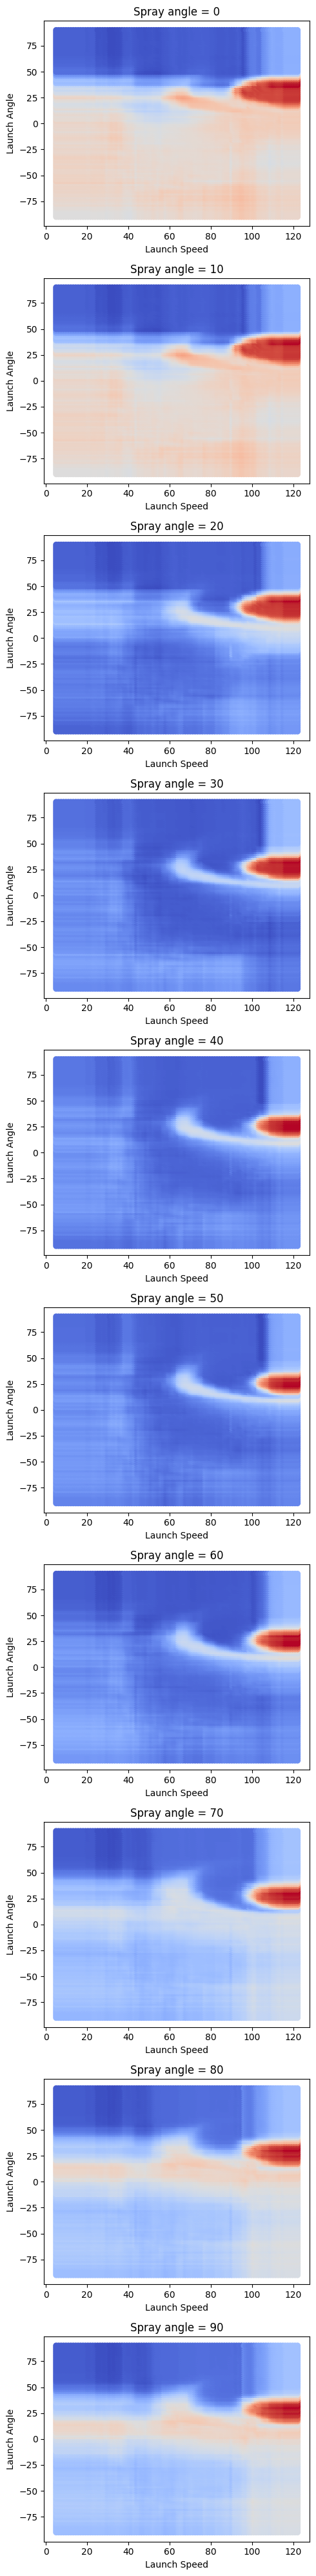

In [39]:
# Generate a grid of launch angles and exit velocities
launch_speeds = np.linspace(df_all_bip['launch_speed'].min(), df_all_bip['launch_speed'].max(), 100)
launch_angles = np.linspace(df_all_bip['launch_angle'].min(), df_all_bip['launch_angle'].max(), 100)
hit_direction_values = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90]

launch_speeds_grid, launch_angles_grid = np.meshgrid(launch_speeds, launch_angles)

fig, axs = plt.subplots(len(hit_direction_values), figsize=(5, 4*len(hit_direction_values)))

for i, hit_direction in enumerate(hit_direction_values):
    print(hit_direction)
    X_grid = np.c_[launch_speeds_grid.ravel(), launch_angles_grid.ravel(), np.full(launch_speeds_grid.ravel().shape, hit_direction)]
    y_grid = xgb_reg.predict(X_grid)
    y_grid = y_grid.reshape(launch_speeds_grid.shape)

    axs[i].scatter(launch_speeds_grid, launch_angles_grid, c=y_grid, cmap='coolwarm')
    axs[i].set_title(f'Spray angle = {hit_direction}')
    axs[i].set_xlabel('Launch Speed')
    axs[i].set_ylabel('Launch Angle')

plt.tight_layout()
plt.show()

In [40]:
# Loop over each year and generate predictions
for year in range(2020, 2024):
    print("generating predictions for", year)
    # Prepare a subset for the current year where all required columns are not null
    df_subset = df_all[(df_all['game_year'] == year) & (df_all['description'] == 'hit_into_play')].dropna(subset=['launch_speed', 'launch_angle', 'spray_angle_adj', 'delta_run_exp'])

    # Store the original indices
    original_indices = df_subset.index

    # Reset the index of df_subset
    df_subset = df_subset.reset_index(drop=True)

    # Predict on the subset
    predictions = xgb_reg.predict(df_subset[['launch_speed', 'launch_angle', 'spray_angle_adj']])

    # Create a Series with the predictions and the original indices
    predictions_series = pd.Series(predictions, index=original_indices)

    # Assign the predictions back to the original DataFrame
    df_all.loc[original_indices, 'predicted_delta_run_exp'] = predictions_series

# For rows without launch speed and angle data, use the actual delta_run_exp
# df_all['predicted_delta_run_exp'].fillna(df_all['delta_run_exp'], inplace=True)


generating predictions for 2020
generating predictions for 2021
generating predictions for 2022
generating predictions for 2023


In [41]:
df_all.loc[df_all['description']=='hit_into_play'].groupby('events')['delta_run_exp', 'predicted_delta_run_exp', 'mean_run_value'].mean()

C:\Users\wampl\AppData\Local\Temp\ipykernel_19000\1202678360.py:1: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



,delta_run_exp,predicted_delta_run_exp,mean_run_value
events,,,
catcher_interf,0.503235,-0.067907,0.412609
double,0.765782,0.268707,0.765790
double_play,-0.358528,0.056635,-0.358472
ejection,-0.098000,0.221876,-0.098000
field_error,0.449070,-0.011137,0.448916
field_out,-0.238021,-0.013588,-0.237867
fielders_choice,0.697381,-0.027674,0.697597
fielders_choice_out,-0.321947,-0.016114,-0.321723
force_out,-0.432533,-0.031055,-0.432398


In [42]:
df_all.loc[df_all['events']=='home_run', ['launch_speed', 'launch_angle', 'stand', 'spray_angle_adj', 'predicted_delta_run_exp']].nsmallest(10, 'predicted_delta_run_exp')

,launch_speed,launch_angle,stand,spray_angle_adj,predicted_delta_run_exp
467990,104.4,17.0,R,30.0,-0.269939
422479,113.3,20.0,L,30.0,-0.268723
46473,94.9,27.0,L,20.0,-0.266579
206197,98.4,43.0,R,10.0,-0.262357
409439,110.9,31.0,R,20.0,-0.262098
37568,91.0,30.0,R,10.0,-0.261092
538506,99.2,37.0,R,30.0,-0.261030
498277,103.9,37.0,L,NaN,-0.260207
83225,109.1,30.0,R,20.0,-0.260158
460809,94.8,34.0,R,20.0,-0.260112


In [43]:
df_all.loc[df_all['description']=='hit_into_play'].groupby('events')[['delta_run_exp', 'predicted_delta_run_exp']].mean()

,delta_run_exp,predicted_delta_run_exp
events,,
catcher_interf,0.503235,-0.067907
double,0.765782,0.268707
double_play,-0.358528,0.056635
ejection,-0.098000,0.221876
field_error,0.449070,-0.011137
field_out,-0.238021,-0.013588
fielders_choice,0.697381,-0.027674
fielders_choice_out,-0.321947,-0.016114
force_out,-0.432533,-0.031055


<AxesSubplot: xlabel='launch_speed', ylabel='launch_angle'>

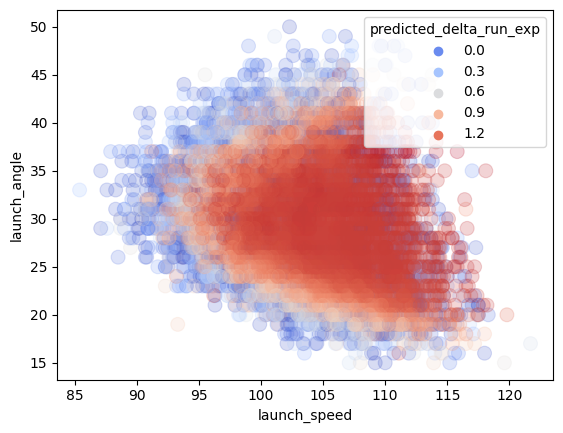

In [51]:
pull_hr = df_all.loc[(df_all['events']=='home_run') & (df_all['spray_angle_adj'] < 30)]

sns.scatterplot(x='launch_speed', y='launch_angle', hue='predicted_delta_run_exp', data=pull_hr, palette='coolwarm', edgecolor=None, s=100, alpha=0.2)

<AxesSubplot: xlabel='launch_speed', ylabel='launch_angle'>

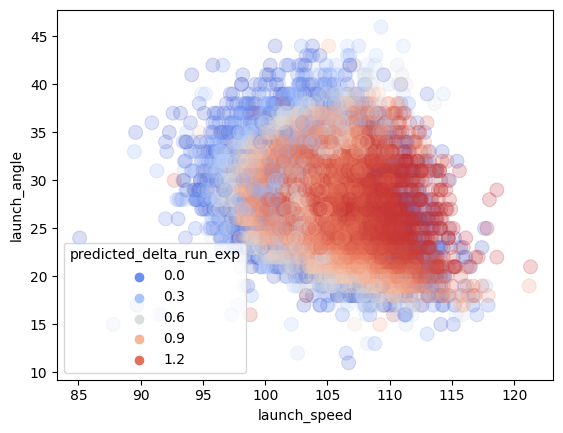

In [52]:
center_hr = df_all.loc[(df_all['events']=='home_run') & (df_all['spray_angle_adj'].isin(range(30, 60)))]
sns.scatterplot(x='launch_speed', y='launch_angle', hue='predicted_delta_run_exp', data=center_hr, palette='coolwarm', edgecolor=None, s=100, alpha=0.2)

<AxesSubplot: xlabel='launch_speed', ylabel='launch_angle'>

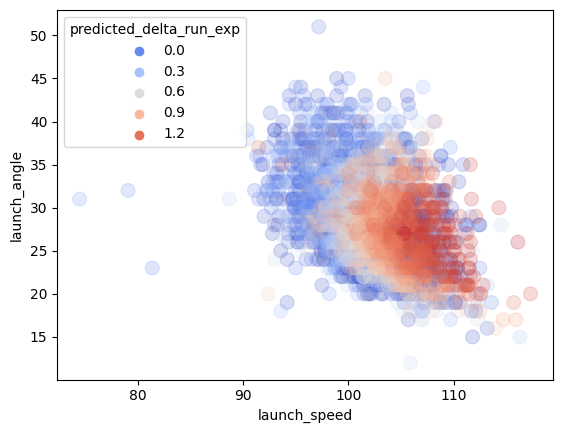

In [53]:
oppo_hr = df_all.loc[(df_all['events']=='home_run') & (df_all['spray_angle_adj'].isin(range(60, 90)))]
sns.scatterplot(x='launch_speed', y='launch_angle', hue='predicted_delta_run_exp', data=oppo_hr, palette='coolwarm', edgecolor=None, s=100, alpha=0.2)

In [25]:
## Calculate vertical approach angle (degrees) for each pitch

df_all['vaa'] = np.arctan((df_all['plate_z'] - df_all['release_pos_z']) / (60.5 - df_all['release_extension'])) * (180 / np.pi)

In [26]:
df_all.loc[(df_all['pitch_type']=='FF') & (df_all['p_throws'] == 'L')].groupby(['player_name', 'pitch_type'], as_index=False)['vaa'].agg(['mean', 'count']).reset_index().sort_values('count', ascending=False).head(50)

,player_name,pitch_type,mean,count
375,"Ray, Robbie",FF,-3.598346,9591
439,"Snell, Blake",FF,-4.166638,8879
169,"Happ, J.A.",FF,-3.689840,8571
384,"Rodriguez, Eduardo",FF,-3.265200,7934
369,"Quintana, José",FF,-3.296153,7630
212,"Kershaw, Clayton",FF,-3.973762,7467
53,"Bumgarner, Madison",FF,-3.178310,7166
345,"Paxton, James",FF,-3.882730,7158
188,"Hill, Rich",FF,-3.282456,6805
237,"Lester, Jon",FF,-3.405291,6758


In [27]:
df_all.loc[(df_all['pitcher']==690986) & (df_all['pitch_type']=='FF') & (df_all['p_throws'] == 'L'), 'az'].mean()

-16.005444934411166

In [28]:
pd.set_option('display.max_columns', None)
df_all.head()

,Unnamed: 0,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,spin_dir,spin_rate_deprecated,break_angle_deprecated,break_length_deprecated,zone,des,game_type,stand,p_throws,home_team,away_team,type,hit_location,bb_type,balls,strikes,game_year,pfx_x,pfx_z,plate_x,plate_z,on_3b,on_2b,on_1b,outs_when_up,inning,inning_topbot,hc_x,hc_y,tfs_deprecated,tfs_zulu_deprecated,fielder_2,umpire,sv_id,vx0,vy0,vz0,ax,ay,az,sz_top,sz_bot,hit_distance_sc,launch_speed,launch_angle,effective_speed,release_spin_rate,release_extension,game_pk,pitcher.1,fielder_2.1,fielder_3,fielder_4,fielder_5,fielder_6,fielder_7,fielder_8,fielder_9,release_pos_y,estimated_ba_using_speedangle,estimated_woba_using_speedangle,woba_value,woba_denom,babip_value,iso_value,launch_speed_angle,at_bat_number,pitch_number,pitch_name,home_score,away_score,bat_score,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment,spin_axis,delta_home_win_exp,delta_run_exp,index,hc_x_adj,hc_y_adj,field_x,field_y,theta,spray_angle,spray_angle_adj,mean_run_value,predicted_delta_run_exp,vaa
0,2664.0,SI,2015-10-04,97.2,-1.20,6.39,"Familia, Jeurys",150029,544727,field_out,hit_into_play,NaN,NaN,NaN,NaN,7.0,Jayson Werth flies out to center fielder Juan ...,R,R,R,NYM,WSH,X,8.0,fly_ball,0,1,2015,-1.02,0.18,-0.71,2.02,NaN,547180.0,NaN,2,9,Top,110.32,71.66,NaN,NaN,518595,NaN,151004_174434,4.057354,-142.293238,-5.635259,-14.347,32.145,-28.506,3.64,1.67,345.0,95.2,35.0,96.5,2018.0,6.1,416079,544727,518595,446263,502517,431151,514913,624424,501571,434158,54.5,0.153,0.293,0.00,1.0,0.0,0.0,3.0,61,2,Sinker,1,0,0,1,0,1,0,1,Standard,Standard,NaN,0.112,-0.256,NaN,-15.68,182.84,118.199970,140.374838,0.870947,49.901581,40.0,-0.225343,-0.216698,-4.592758
1,2715.0,SI,2015-10-04,97.5,-1.14,6.53,"Familia, Jeurys",150029,544727,NaN,called_strike,NaN,NaN,NaN,NaN,3.0,Jayson Werth flies out to center fielder Juan ...,R,R,R,NYM,WSH,S,NaN,NaN,0,0,2015,-0.97,0.50,0.44,3.50,NaN,547180.0,NaN,2,9,Top,NaN,NaN,NaN,NaN,518595,NaN,151004_174405,6.846646,-142.731653,-2.960214,-14.306,32.100,-24.835,3.64,1.67,NaN,NaN,NaN,96.5,2093.0,6.0,416079,544727,518595,446263,502517,431151,514913,624424,501571,434158,54.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,61,1,Sinker,1,0,0,1,0,1,0,1,Standard,Standard,NaN,0.000,-0.048,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-3.182159
2,2844.0,SI,2015-10-04,98.4,-1.19,6.37,"Familia, Jeurys",547180,544727,double,hit_into_play,NaN,NaN,NaN,NaN,4.0,"Mets challenged (tag play), call on the field ...",R,L,R,NYM,WSH,X,7.0,ground_ball,0,0,2015,-1.42,0.26,-0.35,2.45,NaN,NaN,NaN,2,9,Top,73.19,139.24,NaN,NaN,518595,NaN,151004_174011,6.123152,-144.154060,-4.814211,-20.489,36.599,-27.465,3.19,1.46,20.0,72.2,-6.0,97.6,1960.0,6.4,416079,544727,518595,446263,502517,431151,514913,624424,501571,434158,54.5,0.093,0.084,1.25,1.0,1.0,1.0,2.0,60,1,Sinker,1,0,0,1,0,1,0,1,Standard,Strategic,NaN,-0.077,0.208,NaN,-52.81,115.26,44.158818,118.843437,1.215035,69.616375,70.0,0.749887,NaN,-4.144318
3,2907.0,SI,2015-10-04,97.7,-1.15,6.34,"Familia, Jeurys",607208,544727,strikeout,swinging_strike,NaN,NaN,NaN,NaN,13.0,Trea Turner strikes out swinging.,R,R,R,NYM,WSH,S,2.0,NaN,3,2,2015,-1.18,0.32,-0.05,1.27,NaN,NaN,NaN,1,9,Top,NaN,NaN,NaN,NaN,518595,NaN,151004_173928,6.112675,-142.827525,-7.972185,-16.942,31.897,-26.150,3.50,1.61,NaN,NaN,NaN,97.1,2099.0,6.3,416079,544727,518595,446263,502517,431151,514913,624424,501571,434158,54.5,NaN,NaN,0.00,1.0,0.0,0.0,NaN,59,7,Sinker,1,0,0,1,0,1,0,1,Standard,Standard,NaN,0.052,-0.200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.207846,0.027997,-5.344036
4,3097.0,SI,2015-10-04,98.2,-1.15,6.34,"Familia, Jeurys",607208,544727,NaN,foul,NaN,NaN,NaN,NaN,7.0,Trea Turner strikes out swinging.,R,R,R,NYM,WSH,S,NaN,NaN,3,2,2015,-0.87,0.50,-0.41,1.56,NaN,NaN,NaN,1,9,Top,NaN,NaN,NaN,NaN,518595,NaN,151004_173902,4.386048,-143.886961,-7.770625,-12.709,36.274,-23.516,3.50,1.61,NaN,NaN,NaN,97.7,2155.0,6.5,416079,544727,51

In [29]:
df_all.loc[(df_all['pitch_type']=='FF') & (df_all['p_throws'] == 'L')].groupby('player_name')['az'].mean().sort_values(ascending=False).head(50)

player_name
Chapman, Aroldis          -9.406437
Hader, Josh               -9.462179
Poche, Colin              -9.731656
Romero, Enny              -9.935097
Wilson, Justin            -9.983212
Doolittle, Sean          -10.473595
Snell, Blake             -10.609782
Bastardo, Antonio        -10.689916
Vesia, Alex              -10.810237
Baragar, Caleb           -10.856588
Means, John              -10.957100
Kershaw, Clayton         -11.091306
Smyly, Drew              -11.157974
Cabrera, Génesis         -11.181072
Narveson, Chris          -11.184966
Gose, Anthony            -11.185299
Lee, Dylan               -11.207799
McGrath, Kyle            -11.391457
Crochet, Garrett         -11.461088
Benjamin, Wes            -11.621942
Wheeler, Jason           -11.668888
Duffy, Danny             -11.673724
McClanahan, Shane        -11.705533
Lopez, José              -11.724135
Araujo, Elvis            -11.793184
Matzek, Tyler            -11.858654
Thielbar, Caleb          -11.875137
Runzler, Dan    

In [57]:
df_23 = df_all.loc[(df_all['game_year']==2023) & (df_all['pitch_type']=='FF')]

In [62]:
df_all['predicted_delta_run_exp'].fillna(df_all['mean_run_value'], inplace=True)
df_all['predicted_delta_run_exp'].fillna(df_all['delta_run_exp'], inplace=True)

In [63]:
df_all.head()

,Unnamed: 0,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,spin_dir,spin_rate_deprecated,break_angle_deprecated,break_length_deprecated,zone,des,game_type,stand,p_throws,home_team,away_team,type,hit_location,bb_type,balls,strikes,game_year,pfx_x,pfx_z,plate_x,plate_z,on_3b,on_2b,on_1b,outs_when_up,inning,inning_topbot,hc_x,hc_y,tfs_deprecated,tfs_zulu_deprecated,fielder_2,umpire,sv_id,vx0,vy0,vz0,ax,ay,az,sz_top,sz_bot,hit_distance_sc,launch_speed,launch_angle,effective_speed,release_spin_rate,release_extension,game_pk,pitcher.1,fielder_2.1,fielder_3,fielder_4,fielder_5,fielder_6,fielder_7,fielder_8,fielder_9,release_pos_y,estimated_ba_using_speedangle,estimated_woba_using_speedangle,woba_value,woba_denom,babip_value,iso_value,launch_speed_angle,at_bat_number,pitch_number,pitch_name,home_score,away_score,bat_score,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment,spin_axis,delta_home_win_exp,delta_run_exp,index,hc_x_adj,hc_y_adj,field_x,field_y,theta,spray_angle,spray_angle_adj,mean_run_value,predicted_delta_run_exp,vaa
0,2664.0,SI,2015-10-04,97.2,-1.20,6.39,"Familia, Jeurys",150029,544727,field_out,hit_into_play,NaN,NaN,NaN,NaN,7.0,Jayson Werth flies out to center fielder Juan ...,R,R,R,NYM,WSH,X,8.0,fly_ball,0,1,2015,-1.02,0.18,-0.71,2.02,NaN,547180.0,NaN,2,9,Top,110.32,71.66,NaN,NaN,518595,NaN,151004_174434,4.057354,-142.293238,-5.635259,-14.347,32.145,-28.506,3.64,1.67,345.0,95.2,35.0,96.5,2018.0,6.1,416079,544727,518595,446263,502517,431151,514913,624424,501571,434158,54.5,0.153,0.293,0.00,1.0,0.0,0.0,3.0,61,2,Sinker,1,0,0,1,0,1,0,1,Standard,Standard,NaN,0.112,-0.256,NaN,-15.68,182.84,118.199970,140.374838,0.870947,49.901581,40.0,-0.225343,-0.216698,-4.592758
1,2715.0,SI,2015-10-04,97.5,-1.14,6.53,"Familia, Jeurys",150029,544727,NaN,called_strike,NaN,NaN,NaN,NaN,3.0,Jayson Werth flies out to center fielder Juan ...,R,R,R,NYM,WSH,S,NaN,NaN,0,0,2015,-0.97,0.50,0.44,3.50,NaN,547180.0,NaN,2,9,Top,NaN,NaN,NaN,NaN,518595,NaN,151004_174405,6.846646,-142.731653,-2.960214,-14.306,32.100,-24.835,3.64,1.67,NaN,NaN,NaN,96.5,2093.0,6.0,416079,544727,518595,446263,502517,431151,514913,624424,501571,434158,54.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,61,1,Sinker,1,0,0,1,0,1,0,1,Standard,Standard,NaN,0.000,-0.048,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.048000,-3.182159
2,2844.0,SI,2015-10-04,98.4,-1.19,6.37,"Familia, Jeurys",547180,544727,double,hit_into_play,NaN,NaN,NaN,NaN,4.0,"Mets challenged (tag play), call on the field ...",R,L,R,NYM,WSH,X,7.0,ground_ball,0,0,2015,-1.42,0.26,-0.35,2.45,NaN,NaN,NaN,2,9,Top,73.19,139.24,NaN,NaN,518595,NaN,151004_174011,6.123152,-144.154060,-4.814211,-20.489,36.599,-27.465,3.19,1.46,20.0,72.2,-6.0,97.6,1960.0,6.4,416079,544727,518595,446263,502517,431151,514913,624424,501571,434158,54.5,0.093,0.084,1.25,1.0,1.0,1.0,2.0,60,1,Sinker,1,0,0,1,0,1,0,1,Standard,Strategic,NaN,-0.077,0.208,NaN,-52.81,115.26,44.158818,118.843437,1.215035,69.616375,70.0,0.749887,0.749887,-4.144318
3,2907.0,SI,2015-10-04,97.7,-1.15,6.34,"Familia, Jeurys",607208,544727,strikeout,swinging_strike,NaN,NaN,NaN,NaN,13.0,Trea Turner strikes out swinging.,R,R,R,NYM,WSH,S,2.0,NaN,3,2,2015,-1.18,0.32,-0.05,1.27,NaN,NaN,NaN,1,9,Top,NaN,NaN,NaN,NaN,518595,NaN,151004_173928,6.112675,-142.827525,-7.972185,-16.942,31.897,-26.150,3.50,1.61,NaN,NaN,NaN,97.1,2099.0,6.3,416079,544727,518595,446263,502517,431151,514913,624424,501571,434158,54.5,NaN,NaN,0.00,1.0,0.0,0.0,NaN,59,7,Sinker,1,0,0,1,0,1,0,1,Standard,Standard,NaN,0.052,-0.200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.207846,0.027997,-5.344036
4,3097.0,SI,2015-10-04,98.2,-1.15,6.34,"Familia, Jeurys",607208,544727,NaN,foul,NaN,NaN,NaN,NaN,7.0,Trea Turner strikes out swinging.,R,R,R,NYM,WSH,S,NaN,NaN,3,2,2015,-0.87,0.50,-0.41,1.56,NaN,NaN,NaN,1,9,Top,NaN,NaN,NaN,NaN,518595,NaN,151004_173902,4.386048,-143.886961,-7.770625,-12.709,36.274,-23.516,3.50,1.61,NaN,NaN,NaN,97.7,2155.0,6.5,41607

In [64]:
import plotly.express as px

grouped_df = df_23.groupby('player_name').agg({'release_pos_z':'mean', 'az':'mean', 'release_speed':'mean', 'predicted_delta_run_exp':'mean'}).reset_index()
grouped_df = grouped_df.loc[grouped_df['release_speed'] > 85]
fig = px.scatter(grouped_df, x='release_pos_z', y='az', color='predicted_delta_run_exp', hover_data=['player_name'])
fig.show()


In [32]:
grouped_df = df_23.loc[df_23['p_throws']=='L'].groupby('player_name').agg({'release_pos_z':'mean', 'az':'mean'}).reset_index()
fig = px.scatter(grouped_df, x='release_pos_z', y='az', hover_data=['player_name'])
fig.show()

In [33]:
stuff_features = ['release_speed', 'release_extension', 'release_pos_x', 'release_pos_z', 'pfx_x', 'pfx_z', 'vaa']